In [195]:
#dependencies
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from pptx import Presentation
import pptx.util
import imageio

In [196]:
input_folder = "./input"
intermediate_results = "./output"
output_file = "./my_slides.pptx"

In [197]:
SUPPORTED_FORMATS = (".BMP", ".DIB", ".JPEG", ".JPG", ".JPE", ".JP2", ".PNG", ".WEBP", ".PBM", ".PGM", ".PPM", ".SR", ".RAS", ".TIFF", ".TIF") #tuple
def isImage(filename):
    return filename.upper().endswith(SUPPORTED_FORMATS)

In [198]:
#make ordered list of image files files in input folder
only_files = [f for f in listdir(input_folder) if isfile(join(input_folder, f))]
only_files.sort()
only_images = list(filter(lambda x: isImage(x), only_files))
only_images

['IMG_8499.JPG',
 'IMG_8500.JPG',
 'IMG_8501.JPG',
 'IMG_8502.JPG',
 'IMG_8503.JPG',
 'IMG_8504.JPG',
 'IMG_8505.JPG',
 'IMG_8506.JPG',
 'IMG_8507.JPG',
 'IMG_8508.JPG',
 'IMG_8509.JPG',
 'IMG_8510.JPG',
 'IMG_8511.JPG',
 'IMG_8512.JPG',
 'IMG_8513.JPG',
 'IMG_8514.JPG',
 'IMG_8515.JPG',
 'IMG_8516.JPG',
 'IMG_8517.JPG']

In [204]:
images = []
colour_images = []
kps = []
des = []
orb = cv2.ORB_create()

for image in only_images:
    relative_path = input_folder + "/" + image
    print("processing: " + relative_path)
    img = cv2.imread(relative_path,0)
    img_colour = cv2.imread(relative_path)

    #img = cv2.resize(img, (0,0) ,fx=0.1, fy=0.1)
    kp = orb.detect(img,None)
    kp, one_des = orb.compute(img, kp)
    kps.append(kp)
    des.append(one_des)
    images.append(img)
    colour_images.append(img_colour)
    
print("images: " + str(len(images)))
print("color images: " + str(len(colour_images)))
print("keypoints: " + str(len(kps)))
print("descriptors: " +  str(len(des)))


    

processing: ./input/IMG_8499.JPG
processing: ./input/IMG_8500.JPG
processing: ./input/IMG_8501.JPG
processing: ./input/IMG_8502.JPG
processing: ./input/IMG_8503.JPG
processing: ./input/IMG_8504.JPG
processing: ./input/IMG_8505.JPG
processing: ./input/IMG_8506.JPG
processing: ./input/IMG_8507.JPG
processing: ./input/IMG_8508.JPG
processing: ./input/IMG_8509.JPG
processing: ./input/IMG_8510.JPG
processing: ./input/IMG_8511.JPG
processing: ./input/IMG_8512.JPG
processing: ./input/IMG_8513.JPG
processing: ./input/IMG_8514.JPG
processing: ./input/IMG_8515.JPG
processing: ./input/IMG_8516.JPG
processing: ./input/IMG_8517.JPG
images: 19
color images: 19
keypoints: 19
descriptors: 19


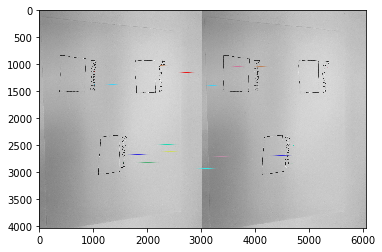

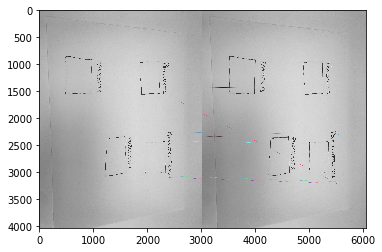

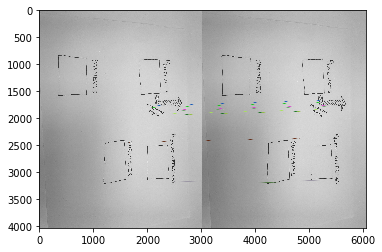

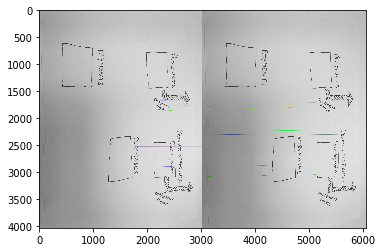

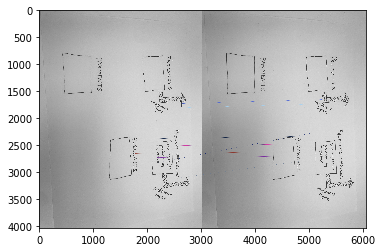

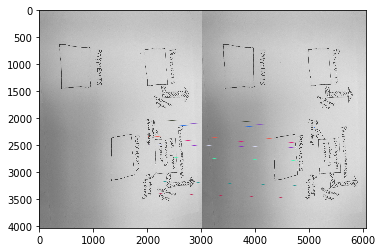

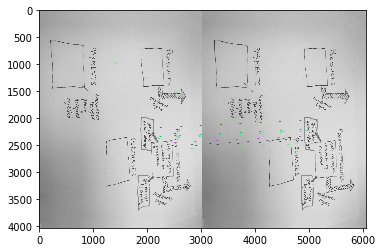

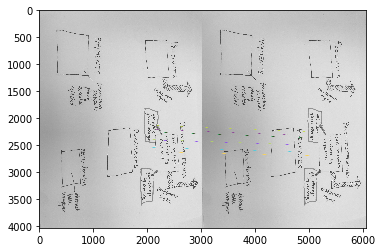

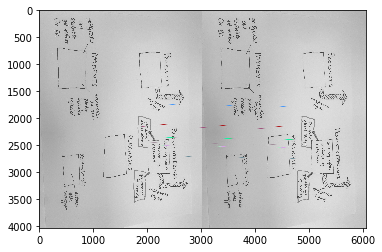

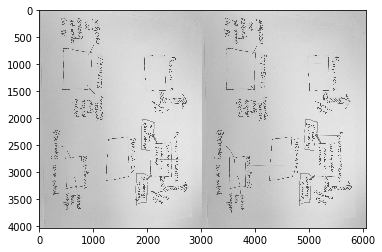

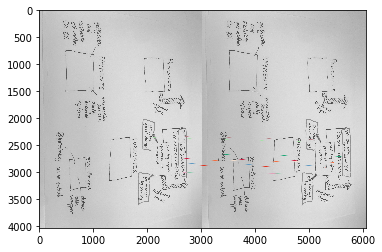

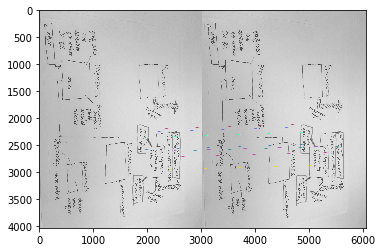

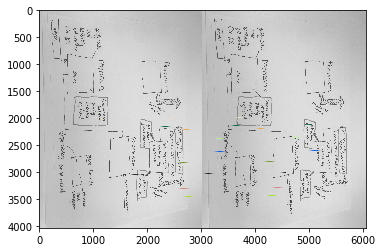

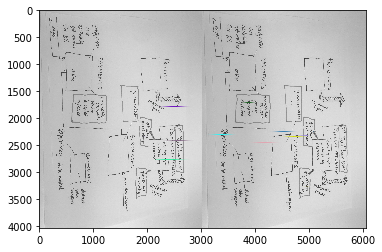

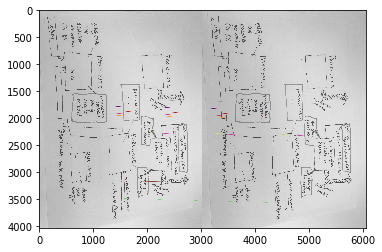

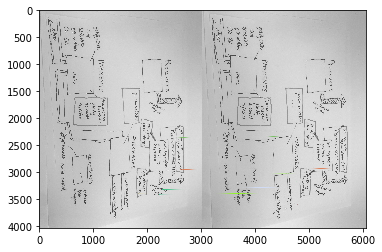

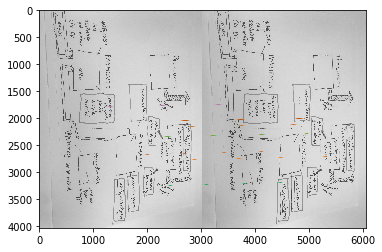

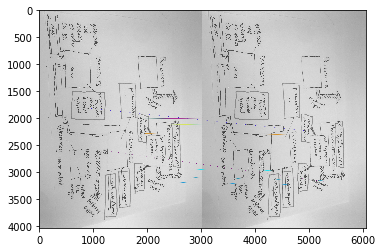

In [200]:
matches_array = []
#match image with previous image. 
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for idx in range(1, len(images)):
    matches = bf.match(des[idx-1], des[idx])
    matches = sorted(matches, key = lambda x:x.distance)
    matches_array.append(matches)
    img3 = cv2.drawMatches(images[idx-1],kps[idx-1],images[idx-1],kps[idx],matches[:10], None, flags=2)
    plt.imshow(img3),plt.show()

In [201]:
'''warp img2 to img1 with homograph H'''
def warpTwoImages(img1, img2, H):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    _pts2 = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, _pts2), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    #result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

0
(3, 3)
(4129, 3055, 3)


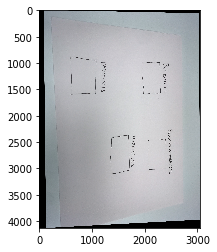

1
(3, 3)
(4533, 3317, 3)


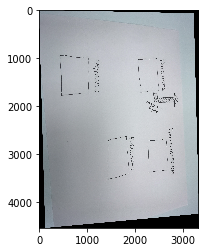

2
(3, 3)
(4966, 3383, 3)


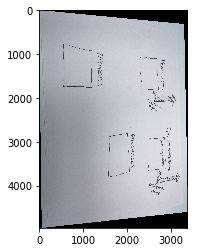

3
(3, 3)
(4476, 3314, 3)


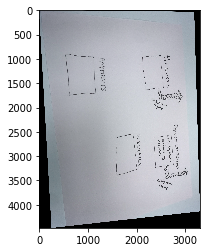

4
(3, 3)
(4948, 3568, 3)


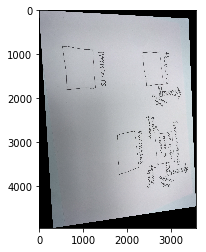

5
(3, 3)
(5472, 3787, 3)


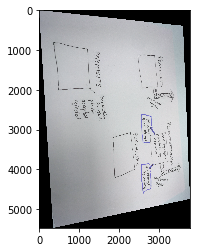

6
(3, 3)
(5299, 3708, 3)


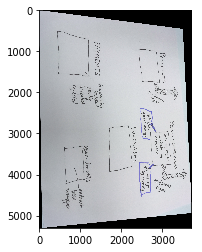

7
(3, 3)
(4614, 3410, 3)


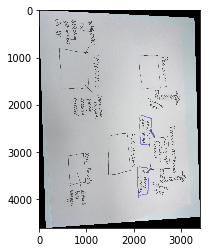

8
(3, 3)
(4675, 3257, 3)


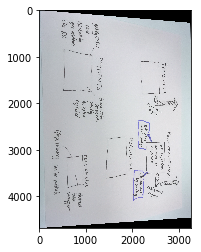

9
(3, 3)
(4729, 3207, 3)


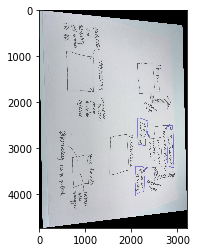

10
(3, 3)
(4496, 3148, 3)


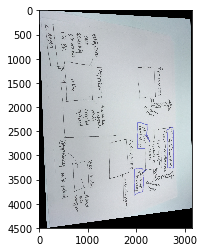

11
(3, 3)
(4415, 3107, 3)


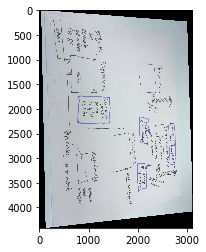

12
(3, 3)
(4383, 3129, 3)


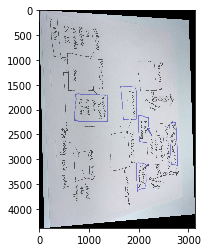

13
(3, 3)
(4325, 3239, 3)


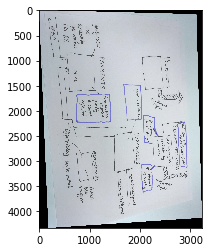

14
(3, 3)
(4302, 3099, 3)


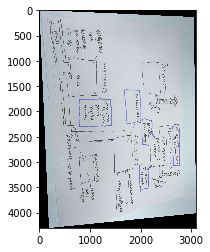

15
(3, 3)
(4489, 3206, 3)


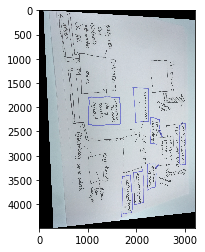

16
(3, 3)
(4340, 3091, 3)


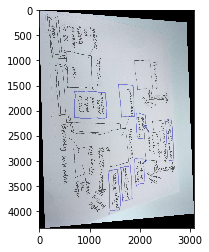

17
(3, 3)
(4377, 3205, 3)


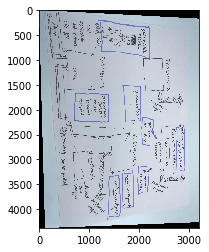

In [205]:
M_tot = np.eye(3)
results = []
for idx, matches in enumerate(matches_array):
    print(idx)
    src_pts = np.array([kps[idx][mat.queryIdx].pt for mat in matches])
    dst_pts =  np.array([kps[idx+1][mat.trainIdx].pt for mat in matches])
    M, mask = cv2.findHomography(src_pts,dst_pts, cv2.RANSAC,5.0)
    print(M.shape)
    M_tot = M_tot.dot(M)
    result = warpTwoImages(colour_images[idx], colour_images[idx+1], M_tot)
    print(result.shape)
    cv2.imwrite(intermediate_results + "/" + only_images[idx+1] , result)
    results.append(result)
    plt.imshow(result),plt.show()

In [ ]:
##TODO. Copy first frame!

In [203]:
#strech each image to a new slide. Proportions of slide will be keept.
BLANK_SLIDE = prs.slide_layouts[6]
prs = Presentation()
# default slide width
#prs.slide_width = 9144000
# slide height @ 4:3
#prs.slide_height = 6858000
# slide height @ 16:9
#prs.slide_height = 5143500
slideAspectRatio = prs.slide_width/prs.slide_height
for image in only_images:
    relative_path = intermediate_results + "/" + image
    slide = prs.slides.add_slide(BLANK_SLIDE)
    shapes = slide.shapes
    picture = shapes.add_picture(relative_path, 0, 0, prs.slide_width, prs.slide_height)
    
prs.save(output_file)

/home/gussan/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ppt/slideLayouts/slideLayout7.xml'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/gussan/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ppt/slideLayouts/_rels/slideLayout7.xml.rels'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/gussan/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ppt/slideMasters/slideMaster1.xml'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/gussan/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ppt/slideMasters/_rels/slideMaster1.xml.rels'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/gussan/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ppt/slideLayouts/slideLayout11.xml'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/gussan/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate 